In [22]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from audioDataset import AudioDataset
from utils import *
from scipy.io import wavfile
import os
from scipy.signal import stft, istft, check_NOLA # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
from dimensionalityReduction import decomposeAudioSKLearn, decomposeAudio

dict_keys(['brass', 'keyboard', 'string'])
[886, 321, 814]
dict_keys(['brass', 'keyboard', 'string'])
[156, 65, 154]
{'window': 'hann', 'nperseg': 1024, 'noverlap': 256}


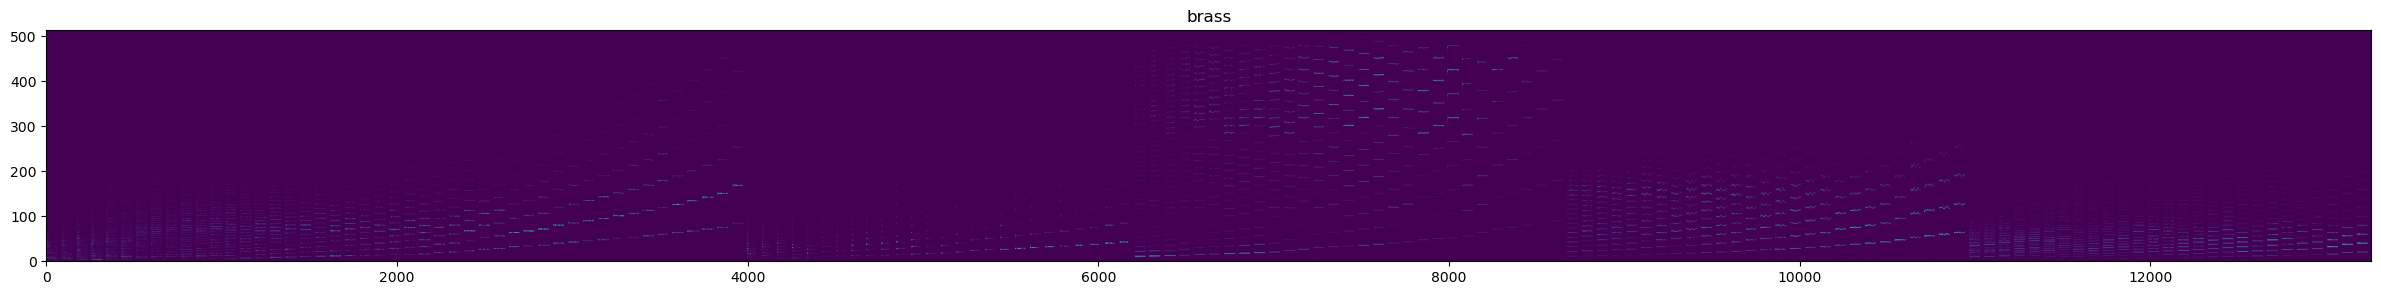

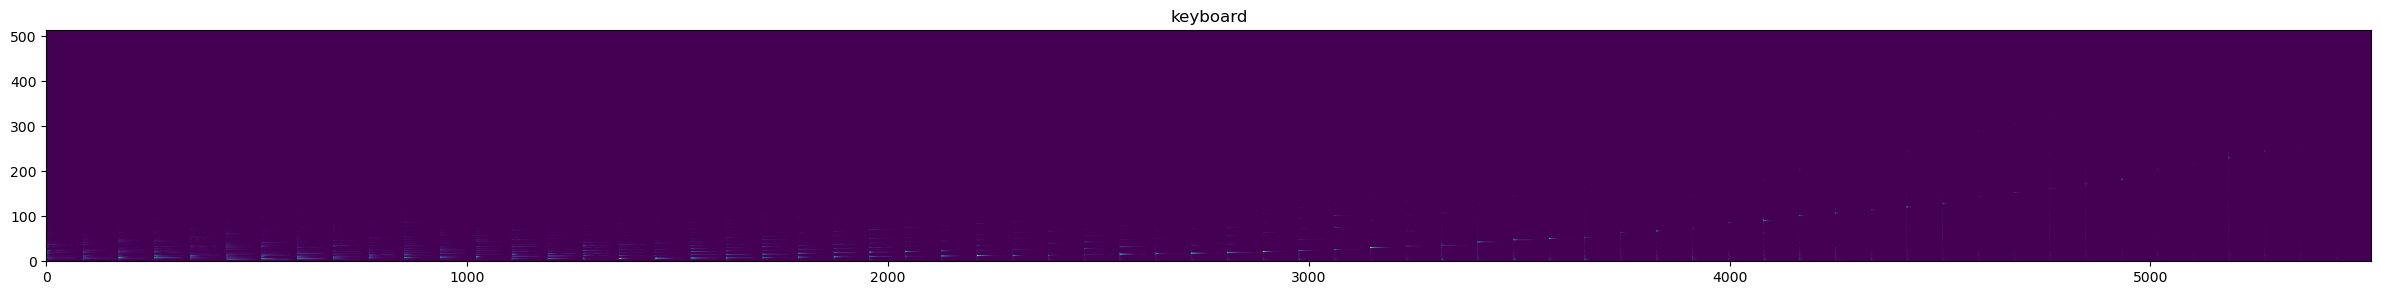

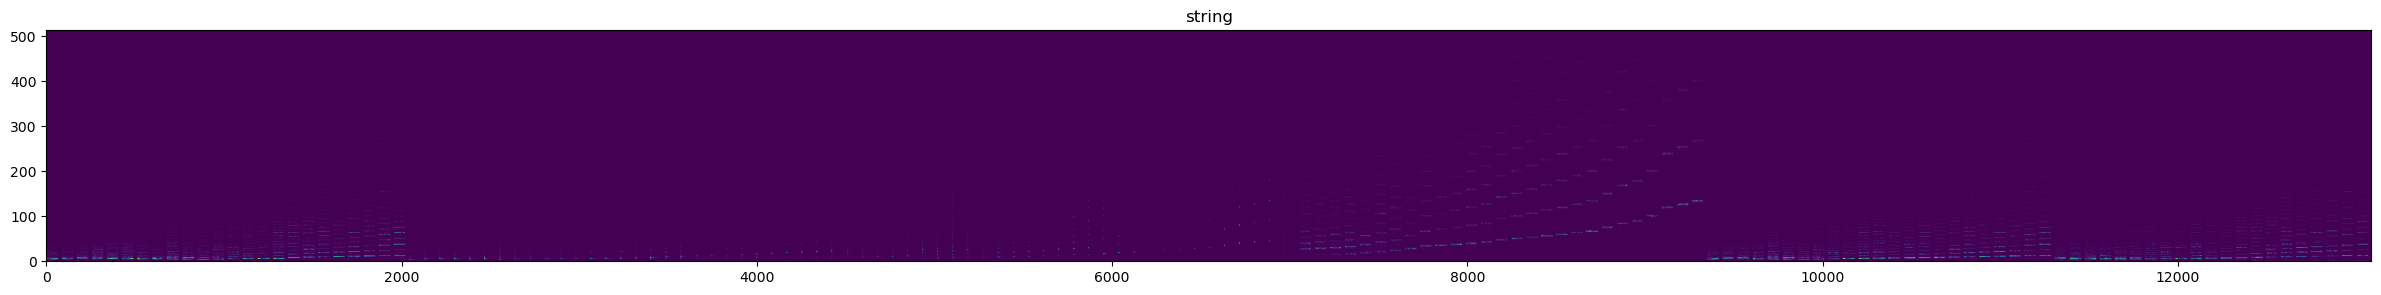

In [24]:
audioDataset = AudioDataset('nsynth-valid', instruments=['keyboard', 'string', 'brass'], kwargs={'nsynth_getAcousticOnly':True})
# audioDataset.normalizeAudioData_()
data = audioDataset.getAudioData()
print(data.keys())
print([len(val) for val in data.values()])

# TODO: When deleting redundant audio data with all NSynth acoustic instruments, the last 3 instruments get completely removed. This may be a bug
audioDataset.deleteRedundantAudioData(pitchInterval=1, writeDebugFiles=False)
data = audioDataset.getAudioData() # data is all float32, but seems the same range
print(data.keys())
print([len(val) for val in data.values()])

audioDataset.setSpectrogramKwargs({'window': 'hann', 'nperseg':1024, 'noverlap':256})
print(audioDataset.getSpectrogramKwargs())


# audioData = audioDataset.getAudioData()
# cycledData = None
# for instrument, currentInstrumentData in audioData.items():
#     bigAudioData = np.array(currentInstrumentData).reshape(-1)
#     cycledData = audioDataset._cycleSTFT(bigAudioData)
#     normalized = normalizeWAV(cycledData)
#     normalized = convertFloat32toInt16(normalized)
        
# audioDataset._writeDebugSample(normalized, fn='cycledBigAudio')


audioDataset.createSpectrogramsIndependent(deleteAudioData=False)
# audioDataset.createSpectrogramsUnified(deleteAudioData=False)
# @ 17.1 GB IRMAS

# Display the spectrograms for each instrument before and after low energy pruning

audioDataset.displayInstrumentSpectrograms()
# audioDataset.removeLowEnergyFrames_(threshold=100)
# audioDataset.displayInstrumentSpectrograms()



audioDataset.writeBasisFunctionAudioFiles()

### Create a "test sample" based on existing basis functions the model knows

9


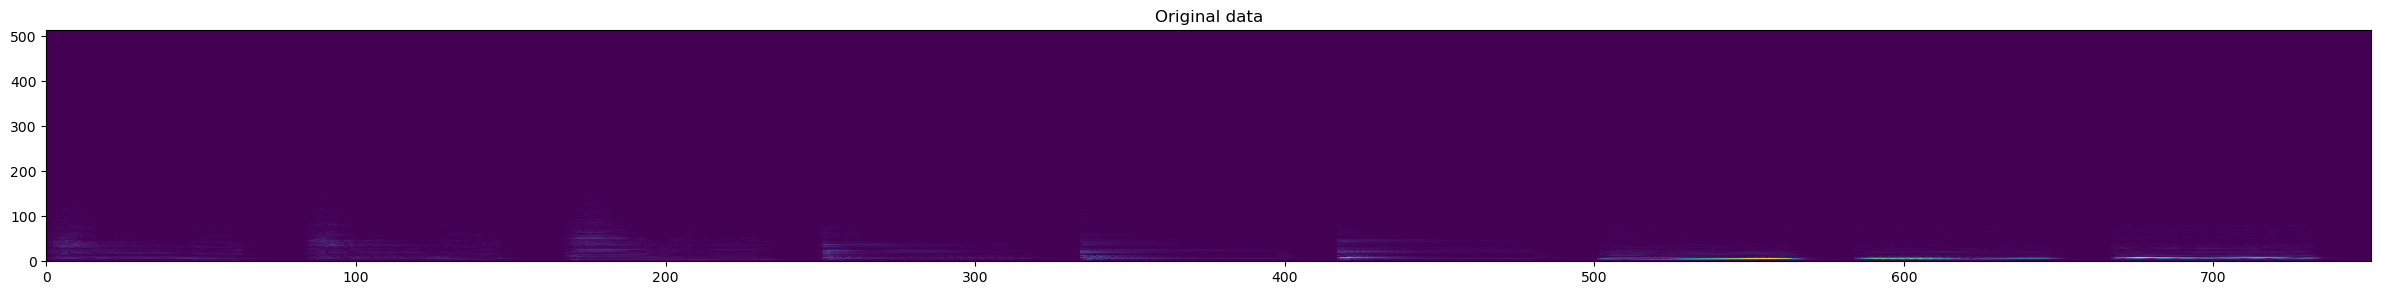

minSpec: (-8201.32421875+1806.753173828125j) maxSpec: (7966.96728515625+672.4996948242188j)
minRaw: -32767 maxRaw: 31585


In [25]:
fs = audioDataset.getMinSampleRate()

audioData = audioDataset.getAudioData()

randomData = []

for instrumentName, dataList in audioData.items():
    
    for idx, sample in enumerate(dataList):
        if idx in [0, 1, 2]:
            randomData.append(sample)

print(len(randomData))
testAudio = np.concatenate(randomData, axis=0)

magnitude, phase = audioDataset.getMagnitudePhaseSpectrogram(data=testAudio, fs=audioDataset.getMinSampleRate())
plt.figure(figsize=(30, 3)), plt.pcolormesh(magnitude), plt.title('Original data'), plt.show()

# for instrumentName, specs in audioDataset.getSpectrograms().items():
    
#     for idx, spec in enumerate(specs):
        
#         if idx in [10, 11, 12]:
#             randomData.append(spec)
#             print(spec.shape)
#             pass
        
#         pass

recombination = magnitude * np.exp(1j * phase)

assert check_NOLA(**audioDataset.getSpectrogramKwargs())
print(f'minSpec: {np.min(recombination)} maxSpec: {np.max(recombination)}')
t, x = istft(recombination, fs=fs, **audioDataset.getSpectrogramKwargs())

x = normalizeWAV(x)
x = convertFloat32toInt16(x)
print(f'minRaw: {np.min(x)} maxRaw: {np.max(x)}')
wavfile.write(f'uniform-SR-test-data\\reconstruction.wav', rate=fs, data=x)

Retrieved test SR is 16000


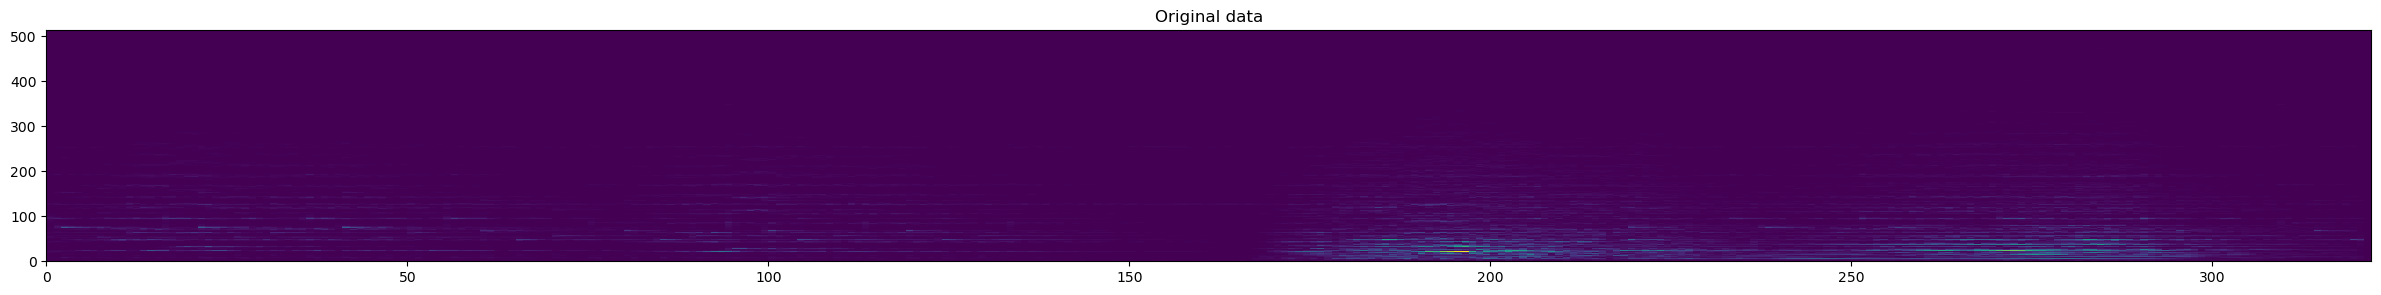

minSpec: (-2642.144287109375-365.2915954589844j) maxSpec: (3704.705078125+84.62564849853516j)
minRaw: -32767 maxRaw: 32764


In [4]:
TEST_FILENAME = r"uniform-SR-test-data\Danse des LuciolesInt16ShortNormalized.wav"
# TEST_FILENAME = r"uniform-SR-test-data\Danse des Lucioles.wav"
fs, rawData = wavfile.read(TEST_FILENAME) # read as int16
print(f'Retrieved test SR is {fs}')
if rawData.ndim > 1:
    rawData = np.mean(rawData, axis=1).astype(np.float32)

testAudio = rawData

# Split off a smaller portion of test audio before getting spectrograms


magnitude, phase = audioDataset.getMagnitudePhaseSpectrogram(data=testAudio, fs=audioDataset.getMinSampleRate())
plt.figure(figsize=(30, 3)), plt.pcolormesh(magnitude), plt.title('Original data'), plt.show()

recombination = magnitude * np.exp(1j * phase)

assert check_NOLA(**audioDataset.getSpectrogramKwargs())
print(f'minSpec: {np.min(recombination)} maxSpec: {np.max(recombination)}')
t, x = istft(recombination, fs=fs, **audioDataset.getSpectrogramKwargs())

x = normalizeWAV(x)
x = convertFloat32toInt16(x)
print(f'minRaw: {np.min(x)} maxRaw: {np.max(x)}')
wavfile.write(f'uniform-SR-test-data\\reconstruction.wav', rate=fs, data=x)

Finished after 199 iterations
HMin: 0.0 HMax: 28.83786964416504


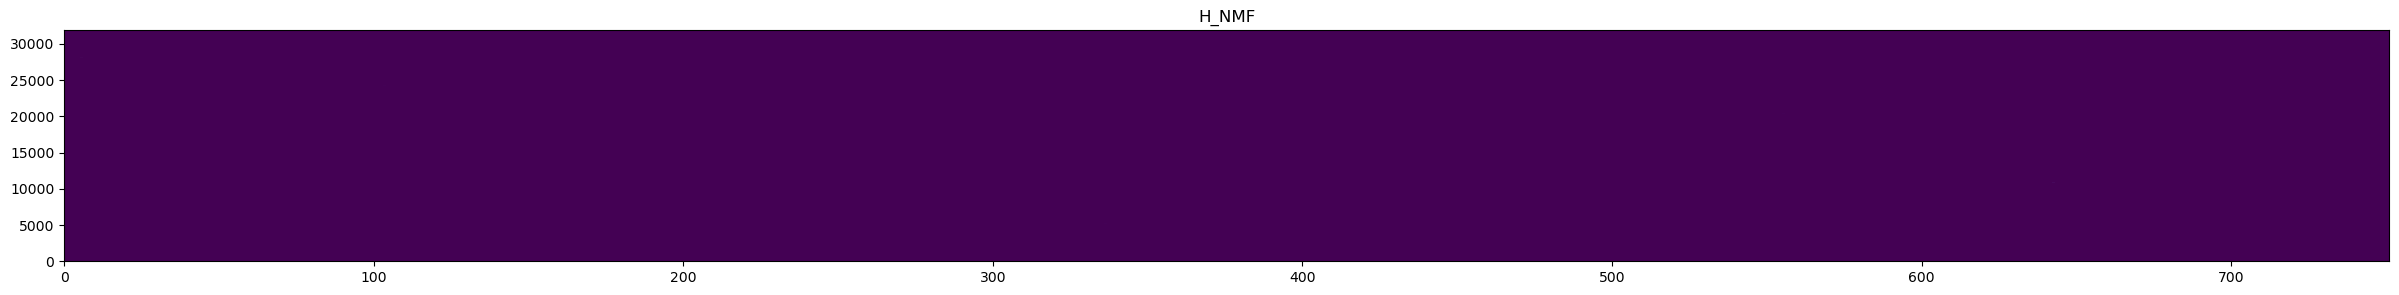

(<Figure size 3000x300 with 1 Axes>,
 Text(0.5, 1.0, 'H_NMF'),
 None)

In [26]:
# Combine all spectrogram data into a large array that can be used for NMF as a basis function array. 
basisFunctions, indexDict = audioDataset.getBasisFunctions() # basisFunctions are float32
# plt.figure(figsize=(30, 3)), plt.pcolormesh(basisFunctions), plt.title('W_NMF'), plt.show()


sampleNums = [0, 1, 2]

samples = magnitude.shape[1]
n = basisFunctions.shape[1]


# W_NMF, H_NMF = decomposeAudioSKLearn(X=magnitude, W=basisFunctions, H=None, regularization=0.1)
W_NMF, H_NMF = decomposeAudio(X=magnitude, W=basisFunctions, iterations=200, wPrime=basisFunctions, alpha=0.001)


print(f'HMin: {np.min(H_NMF)} HMax: {np.max(H_NMF)}')
plt.figure(figsize=(30, 3)), plt.pcolormesh(H_NMF), plt.title('H_NMF'), plt.show()

# Check overlap add for ISTFT
# TODO: Denoising can also be done by adding a "noise" instrument thta will pull out the noise form the samples too
# TODO: Try pre-nmf reduction on the individual instruments to reduce dimensions more before real NMF?
# TODO: Try this https://paris.cs.illinois.edu/pubs/paris-icassp2017.pdf in section 4 experiments.

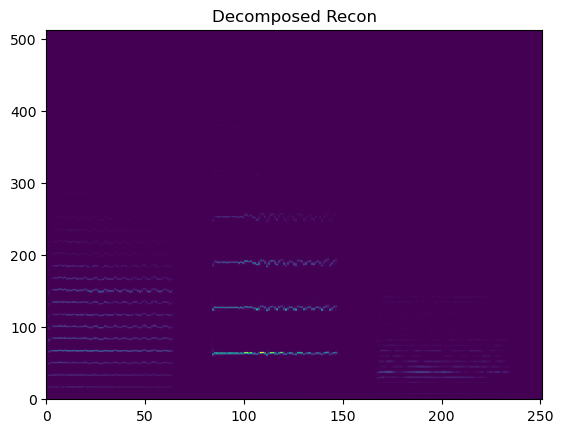

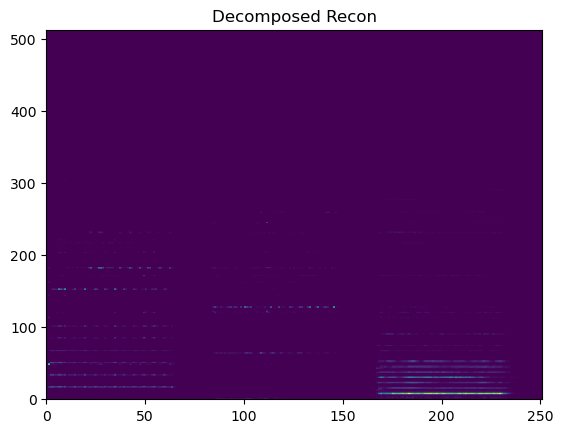

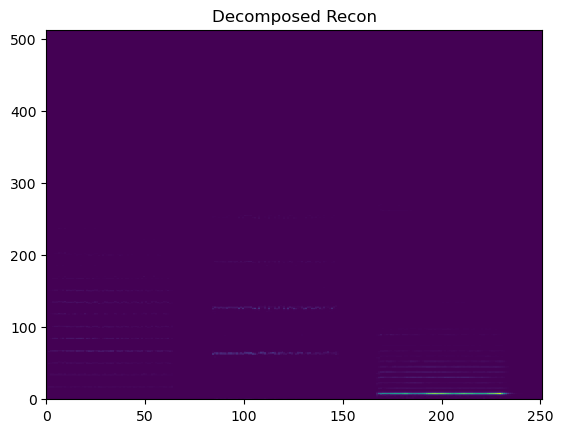

minSpec: (-4082.003662109375-2787.431884765625j) maxSpec: (5006.58056640625+4593.81787109375j)
minRaw: -26085 maxRaw: 32767
minSpec: (-999.0689697265625-209.2910919189453j) maxSpec: (976.10888671875-73.51077270507812j)
minRaw: -24227 maxRaw: 32767
minSpec: (-7901.57861328125+1333.3193359375j) maxSpec: (7830.296875-241.47299194335938j)
minRaw: -32205 maxRaw: 32766


In [8]:
def _reconstructDecompositions(W_NMF:np.ndarray, H_NMF:np.ndarray, phase:np.ndarray, indexDict:dict) -> dict:
    
    """
    Reconstructs instruments from basis functions and activations and writes decompositions to the decompositions folder

    Arguments:
        W_NMF: A numpy array of shape (DIMS, SAMPLES) which represents the basis functions from NMF
        H_NMF: A numpy array of shape (SAMPLES, SPECTROGRAM_LENGTH) which represents the decomposed activations of each instrument from NMF
        indexDict: A dictionary of format ('instrumentName': instrumentLength) which notes how long each basis function is

    Returns:
        isolations: A dictionary of format ('instrumentName': isolation) where isolation is a complex spectrogram which can be converted back to a wav file
    """
    
    isolations = []
    
    currentBase = 0
    
    for instrumentName, indexOffset in indexDict.items():
        currentBasisFunctions = W_NMF[:, currentBase:currentBase+indexOffset]
        currentActivations = H_NMF[currentBase:currentBase+indexOffset, :]
        
        currentReconstruction = (currentBasisFunctions @ currentActivations) * np.exp(1j * phase)
        isolations.append(currentReconstruction)
        plt.pcolormesh(np.abs(currentReconstruction)), plt.title('Decomposed Recon'), plt.show()
        currentBase += indexOffset
    
    return isolations


isolations = _reconstructDecompositions(W_NMF, H_NMF, phase, indexDict)

fs = audioDataset.getMinSampleRate()
for idx, isolation in enumerate(isolations):
    assert check_NOLA(**audioDataset.getSpectrogramKwargs())
    print(f'minSpec: {np.min(isolation)} maxSpec: {np.max(isolation)}')
    t, x = istft(isolation, fs=fs, **audioDataset.getSpectrogramKwargs())

    x = normalizeWAV(x)
    x = convertFloat32toInt16(x)
    print(f'minRaw: {np.min(x)} maxRaw: {np.max(x)}')

    wavfile.write(f'decompositions\\decomposition{idx}.wav', rate=fs, data=x)